# Recommender Systems with Deep Learning


In [1]:
# Importing packages and libraries
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from keras.models import Model
from keras.optimizers import SGD
# from keras.optimizers.legacy import SGD  # For macos compatibility

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Getting data
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2025-03-24 20:31:30--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  15.0MB/s    in 14s     

2025-03-24 20:31:45 (13.2 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
# Unzipping file
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
# Importing data
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
# Turning ids into categorical values
df['userId'] = pd.Categorical(df['userId'])
df['movieId'] = pd.Categorical(df['movieId'])

# Creating new ids from the categorical codes
df['new_user_id'] = df['userId'].cat.codes
df['new_movie_id'] = df['movieId'].cat.codes

In [6]:
# Getting user ids, movie ids and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [7]:
# Getting number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Setting embedding dimension
K = 10

In [8]:
# Splitting the data

# Shuffling arrays
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

# Getting size of training data
N_train = int(0.8 * len(ratings))

# Getting training data
train_user = user_ids[:N_train]
train_movie = movie_ids[:N_train]
train_ratings = ratings[:N_train]

# Getting testing data
test_user = user_ids[N_train:]
test_movie = movie_ids[N_train:]
test_ratings = ratings[N_train:]

# Normalizing the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [9]:
# Creating model

# User and movie inputs
u = Input(shape=(1,))
m = Input(shape=(1,))

# User and movie embeddings
u_emb = Embedding(N, K)(u)
m_emb = Embedding(M, K)(m)

# Flattening both embeddings
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)

# Concatenating embeddings
x = Concatenate()([u_emb, m_emb])

# Dense Layer
x = Dense(1024, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

# Building model
model = Model([u, m], x)

In [10]:
# Compiling model
model.compile(
    loss='mse',
    optimizer=SGD(
        learning_rate=0.08,
        momentum=0.9,
    ),
)

# Training model
r = model.fit(
    [train_user, train_movie],
    train_ratings,
    epochs=25,
    batch_size=1024,
    verbose=2,
    validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 - 54s - 3ms/step - loss: 0.7718 - val_loss: 0.7227
Epoch 2/25
15626/15626 - 33s - 2ms/step - loss: 0.7022 - val_loss: 0.6977
Epoch 3/25
15626/15626 - 33s - 2ms/step - loss: 0.6814 - val_loss: 0.6865
Epoch 4/25
15626/15626 - 33s - 2ms/step - loss: 0.6658 - val_loss: 0.6755
Epoch 5/25
15626/15626 - 33s - 2ms/step - loss: 0.6546 - val_loss: 0.6702
Epoch 6/25
15626/15626 - 33s - 2ms/step - loss: 0.6430 - val_loss: 0.6658
Epoch 7/25
15626/15626 - 33s - 2ms/step - loss: 0.6304 - val_loss: 0.6574
Epoch 8/25
15626/15626 - 33s - 2ms/step - loss: 0.6163 - val_loss: 0.6456
Epoch 9/25
15626/15626 - 33s - 2ms/step - loss: 0.6053 - val_loss: 0.6412
Epoch 10/25
15626/15626 - 33s - 2ms/step - loss: 0.5965 - val_loss: 0.6400
Epoch 11/25
15626/15626 - 33s - 2ms/step - loss: 0.5880 - val_loss: 0.6405
Epoch 12/25
15626/15626 - 33s - 2ms/step - loss: 0.5795 - val_loss: 0.6362
Epoch 13/25
15626/15626 - 33s - 2ms/step - loss: 0.5712 - val_loss: 0.6410
Epoch 14/25
15626/15626 - 33s - 2m

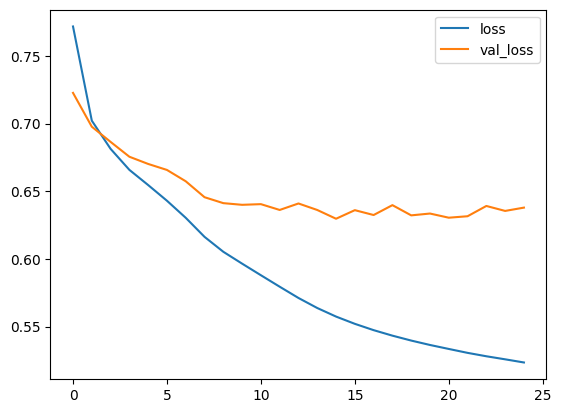

In [11]:
# Plotting performance
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()